In [85]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


### Подготовка данных

In [86]:
def prepare_df(path_to_df):
    df = pd.read_csv(path_to_df, encoding='utf-16', header=None)
    df.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    df = df.set_index("1")
    return df

In [87]:
train_df = prepare_df("./Train/markup_wo_inverted.csv")
test_df = prepare_df("markup.csv")

In [88]:
train_df, val_df = train_test_split(train_df, test_size=0.15)

In [89]:
train_df

,0,2,3,4,5,6,7,8,9,10
1,,,,,,,,,,
4612457542177,d61054500b767befa015aa36601eee74.png,25,266,18,27,128,27,132,262,1010101111011001100100110100011011100100100010...
4680024812108,92a1e433b1c34ede3299fbdcee38c5ff.png,449,2199,345,735,896,733,1036,2181,1010101111000100100011010001101001101100111010...
5902057001748,6b58a8e52e96e185f2b988816d682170.png,611,771,1919,572,1973,1485,779,1717,1010001011010011100110110001101011000100100010...
4690326173418,aa29f4286fde14f589ca85cf1e6e9efb.png,327,162,943,117,951,303,317,352,1010101111001011100011010111101001101100001010...
5900017814100,8249575193d5e5786bc0466e4d6cdb24.png,826,472,2474,440,2479,1320,826,1320,1010001011010011101001110001101001100100100010...
...,...,...,...,...,...,...,...,...,...,...
20714269920,1bff4bb63e1f87933e3458d402e2b600.png,157,1304,247,446,471,458,381,1338,1010001101001001100011010111011001100101000110...
4606068257507,4fa1ef105bf669c00df91bb10007b6e9.png,46,77,386,77,391,214,49,232,1010101111010011101011110001101000010100010010...
4650055991165,90f296ee39da1cf376fbb7ab04a89867.png,694,344,2136,324,2112,938,736,972,1010101111011100100011010001101011100101110010...


### Загрузка данных

In [104]:
class BarCodesDataset(Dataset):
    def __init__(self, markup, mode):
        super().__init__()
        self.files = np.array(markup.loc[:, "0":"9"])
        self.len_ = len(self.files)
        self.mode = mode

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = cv2.imread(file)
        return np.array(image)

    def get_mask(self, idx, mask_shape):
        points = np.array(self.files[idx][1:]).reshape((4, 2))
        points = points.astype("int64")
        mask_img = np.zeros(shape=mask_shape)
        mask = cv2.fillPoly(mask_img, [points], color=(255,255,255))
        return mask

    def __getitem__(self, index):
        transform = transforms.Compose([
                transforms.ToTensor(), 
                transforms.Resize(size=(64, 64))])
        if self.mode == "train":
            path_to_file = "./Train/Images/"
            x = self.load_sample(path_to_file + self.files[index][0])
            size = x.shape[:2]
            y = self.get_mask(index, (x.shape[0], x.shape[1]))
            x = transform(x)
            y = transform(y)
            return x, y
        else:
            path_to_file = "./Test/Images/"
            x = self.load_sample(path_to_file + self.files[index][0])
            size = x.shape[:2]
            x = transform(x)
            return x, size, self.files[index][0]

In [105]:
train_dataset = BarCodesDataset(train_df[:3000], mode="train")
val_dataset = BarCodesDataset(val_df, mode="train")
test_dataset = BarCodesDataset(test_df, mode="test")

In [106]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=8, shuffle=False)

### Модель

In [93]:
import torch.nn as nn
import torch.nn.functional as F

In [94]:
class DualConv(nn.Module):
    def __init__(self, input_ch, output_ch):
        super(DualConv, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(input_ch, output_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(output_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_ch, output_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(output_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv_block(x)
    

class Contract(nn.Module):
    def __init__(self, input_ch, output_ch):
        super(Contract, self).__init__()
        self.down_conv = nn.Sequential(nn.MaxPool2d(2), DualConv(input_ch, output_ch))
    def forward(self, x):
        return self.down_conv(x)
    
class Expand(nn.Module):
    def __init__(self, input_ch, output_ch):
        super(Expand, self).__init__()
        self.up = nn.ConvTranspose2d(input_ch, input_ch // 2, kernel_size=2, stride=2)
        self.conv = DualConv(input_ch, output_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]
        x1 = F.pad(
            x1, [diff_x // 2, diff_x - diff_x // 2, diff_y // 2, diff_y - diff_y // 2]
        )
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class FinalConv(nn.Module):
    def __init__(self, input_ch, output_ch):
        super(FinalConv, self).__init__()
        self.conv = nn.Conv2d(input_ch, output_ch, kernel_size=1)
    def forward(self, x):
        return self.conv(x)


class CustomUNet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CustomUNet, self).__init__()
        self.initial = DualConv(input_channels, 64)
        self.down1 = Contract(64, 128)
        self.down2 = Contract(128, 256)
        self.up1 = Expand(256, 128)
        self.up2 = Expand(128, 64)
        self.final = FinalConv(64, num_classes)
    def forward(self, x):
        x1 = self.initial(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)

        x = self.up1(x3, x2)
        x = self.up2(x, x1)
        logits = self.final(x)
        return logits

In [95]:
from IPython.display import clear_output

In [96]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    
    train_loss = []
    val_loss = []
    train_score = []
    val_score = []

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        model.train()
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            opt.step()

            avg_loss += loss / len(data_tr)
        print('loss: %f' % avg_loss)

        train_loss.append(avg_loss.detach().cpu().numpy())

        model.eval()
        avg_loss_v = 0
        for X_val, Y_val in data_val:
            with torch.no_grad():
                Y_hat =  model(X_val.to(device)).detach().cpu()
                loss_v = loss_fn(Y_hat, Y_val)
                avg_loss_v += loss_v / len(data_val)

        val_loss.append(avg_loss_v.detach().cpu().numpy())
        clear_output(wait=True)
        for k in range(4):
            plt.subplot(2, 4, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 4, k+5)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        
    return (train_loss, val_loss, train_score, val_score)

In [97]:
def dice_loss(pred, target, smooth=1):
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

### Обучение

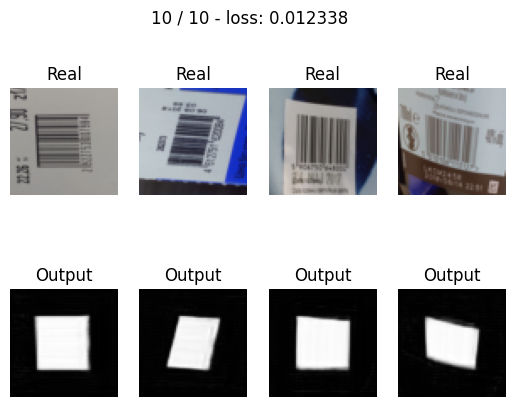

In [107]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CustomUNet(input_channels=3, num_classes=1)
max_epochs = 10
optim = torch.optim.Adam(model.parameters())
losses_and_scores_segnet_bce = train(model, optim, dice_loss, max_epochs, train_dataloader, val_dataloader)

In [108]:
torch.save(model.state_dict(), "weights.pth")

In [99]:
#model = CustomUNet(input_channels=3, num_classes=1)
#model.load_state_dict(torch.load("weights.pth"))
#model.eval()

CustomUNet(
  (initial): DualConv(
    (conv_block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Contract(
    (down_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DualConv(
        (conv_block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

### Тестирование

In [125]:
def finding_corners(mask, transform, path):
    testmask = transform(mask).squeeze()
    mask_contour = (np.round(testmask.cpu().detach().numpy() / 255)).astype("uint8")
    contours, hierarchy = cv2.findContours(mask_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    
    rect = cv2.minAreaRect(largest_contour)
    box = cv2.boxPoints(rect)
    return box

In [126]:
def show_results(model, test_dataset, index):
    img, size, path = test_dataset[index]
    mask = model(img.to(device).unsqueeze(0))
    corners = finding_corners(mask, transforms.Resize([size[0], size[1]]), path)

    img_array = np.array(cv2.imread("./Test/Images/" + path))
    cv2.polylines(img_array, np.int32([corners]), isClosed=True, color=(0,255,255), thickness=5)
    plt.imshow(img_array)

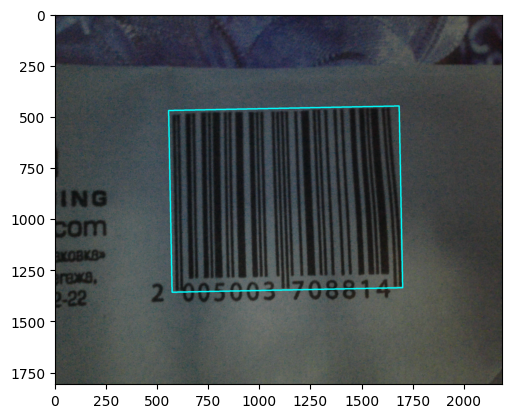

In [127]:
show_results(model, test_dataset, 0)

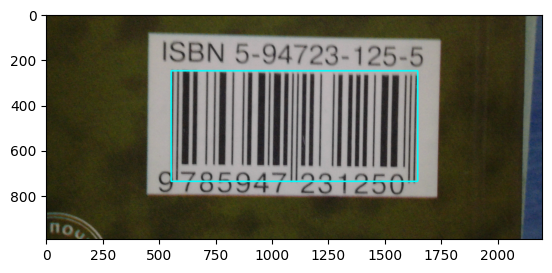

In [128]:
show_results(model, test_dataset, 4)

### Проверка результатов

In [113]:
def testing(model, dataset):
    result = []
    len_test = len(dataset)
    model.eval()
    with torch.no_grad():
        for i in range(len_test):
            img, size, path = dataset[i]
            mask = model(img.to(device).unsqueeze(0))
            corners = finding_corners(mask, transforms.Resize([size[0], size[1]]), path)
            corners = np.round(corners).astype("int32")
            result.append([path, '-', corners[0][0], corners[0][1], corners[1][0], corners[1][1], 
                          corners[2][0], corners[2][1], corners[3][0], corners[3][1], '-'])
    return pd.DataFrame(result)

In [114]:
answer = testing(model, test_dataset)

In [115]:
answer

,0,1,2,3,4,5,6,7,8,9,10
0,5825c9d1deb6572b6dba440d5c6482bf.png,-,555,472,1682,450,1699,1337,573,1359,-
1,f9bf5d96a0cf5d64aac4eb5806554224.png,-,599,1185,661,426,1775,518,1713,1276,-
2,a154b624c06072da1a01c97ebc3894c1.png,-,530,463,1562,290,1641,758,609,931,-
3,749003091876fc58be69db54bbaae8f1.png,-,518,264,1555,230,1568,647,532,680,-
4,560ca4ac1260313eb5979140c4f9ef31.png,-,555,739,555,250,1647,250,1647,739,-
...,...,...,...,...,...,...,...,...,...,...,...
95,bf547f52301ee51df5faf1a6dc678740.png,-,760,195,2319,173,2348,2215,788,2237,-
96,d7d7c5f9109aa31aff407eeab054bfc7.png,-,430,646,1245,607,1317,2091,502,2131,-
97,d6230eb6dc78728c09024eb674c427ef.png,-,235,475,683,457,725,1473,276,1491,-
98,f534d421c7e36d6133a5e9031a7e2dd5.png,-,223,469,651,466,661,1999,234,2002,-


In [116]:
test_df

,0,2,3,4,5,6,7,8,9,10
1,,,,,,,,,,
2005003708814,5825c9d1deb6572b6dba440d5c6482bf.png,569,485,1644,452,1707,1335,583,1356,1010001101000110101110010100111000110101000010...
8594015301013,f9bf5d96a0cf5d64aac4eb5806554224.png,686,446,1833,528,1747,1338,611,1117,1010110001001011101000110100111011001101100010...
4607016245676,a154b624c06072da1a01c97ebc3894c1.png,536,483,1552,313,1608,767,620,939,1010101111010011101110110001101011001100001010...
4602824019426,749003091876fc58be69db54bbaae8f1.png,522,270,1541,229,1566,636,537,688,1010101111010011100100110110111001101100111010...
9785947231250,560ca4ac1260313eb5979140c4f9ef31.png,553,248,1648,265,1637,745,549,736,1010111011000100101110010001011001110101110110...
...,...,...,...,...,...,...,...,...,...,...
4606631340001,bf547f52301ee51df5faf1a6dc678740.png,811,2236,763,242,2290,194,2268,2207,1010101111010011101011110101111010000101100110...
9001414204047,d7d7c5f9109aa31aff407eeab054bfc7.png,515,2018,429,694,1213,603,1288,2101,1010001101010011101100110100011011001101000110...
4810023000156,d6230eb6dc78728c09024eb674c427ef.png,295,1482,235,510,684,494,705,1448,1010110111011001100011010001101001101101000010...


In [117]:
answer.to_csv('answer.csv', header=False, index=False, encoding='utf-16')

In [118]:
from course_intro_ocr_t3.evaluate import main

main()

Checking answer (/home/whiteinc/Documents/ABBYY/course_intro_ocr/task3/answer.csv) against markup(/home/whiteinc/Documents/ABBYY/course_intro_ocr/task3/markup.csv)
recognition_accuracy=0.0
detection_result=1.0
score=1.0
